<a href="https://colab.research.google.com/github/TaraRasti/Deep_Learning_F20_Assignments/blob/master/Assignment%2012/pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
root='/content/drive/MyDrive/Linnaeus/'

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt

(256, 256, 3)


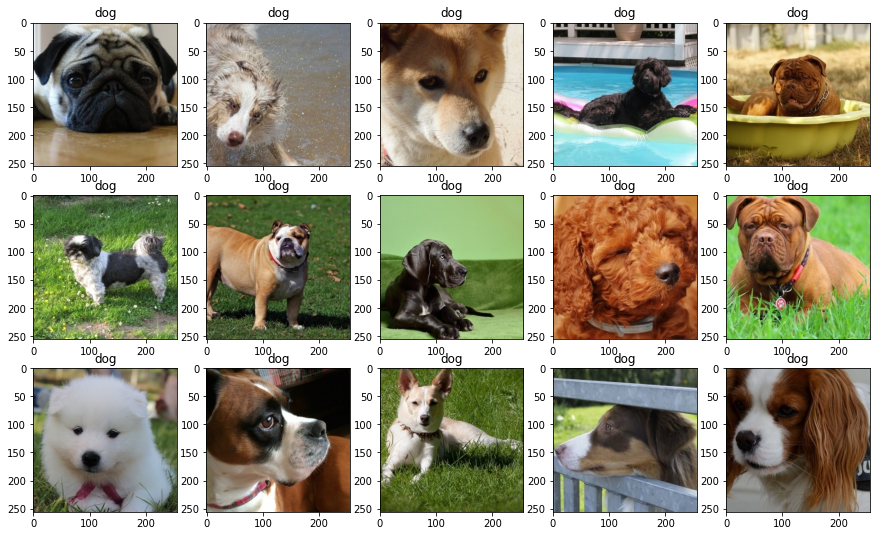

In [11]:
import glob
import matplotlib.pyplot as plt
files = glob.glob(root+'train/*/*.jpg')
fig, axes = plt.subplots(3,5, figsize=(15,9))
for i,ax in enumerate(axes.flat):
    x = plt.imread(files[i])
    y = files[i].split('/')[-2]
    ax.imshow(x)
    ax.set_title(y)
print(x.shape)

In [12]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_ds = datasets.ImageFolder(root=root+'train/',
                                           transform=data_transform)
training_generator = torch.utils.data.DataLoader(train_ds,
                                             batch_size=32, shuffle=True)

validation_ds = datasets.ImageFolder(root=root+'test/',
                                           transform=data_transform)
validation_generator = torch.utils.data.DataLoader(validation_ds,
                                             batch_size=32, shuffle=True)

In [13]:
opt_functional = {'resnet152':lambda x:optim.Adadelta(x.parameters()),
                  'resnet18':lambda x:optim.Adadelta(x.parameters())}
loss_function = nn.CrossEntropyLoss()

In [14]:
from torchvision import models
class ResNet152(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet152 = models.resnet152(pretrained=True)
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,5)
        
    def forward(self, x):
        x = self.resnet152(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.softmax(self.fc5(x),dim=1)
        return x
  
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,5)
        
    def forward(self, x):
        x = self.resnet18(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.softmax(self.fc5(x),dim=1)
        return x

In [8]:
import torch
import numpy as np
max_epochs = 20

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)
torch.backends.cudnn.benchmark = True
cnn_dic = {'resnet18':ResNet18(),
           'resnet152':ResNet152()}
mdl_pool = {}
for name,cnn in cnn_dic.items():
    print('training ' + name)
    optimizer = opt_functional[name](cnn)
    cnn.to(device)
    train_epoch_loss = [] 
    train_epoch_acc = [] 
    val_epoch_loss = []
    val_epoch_acc = [] 
    for epoch in range(max_epochs):
        cnn.train()
        running_loss = []
        running_acc = []
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/training_generator.batch_size]
        train_epoch_loss += [np.mean(running_loss)]
        train_epoch_acc += [np.mean(running_acc)]
        
        running_loss = []
        running_acc = []
        with torch.no_grad():
            cnn.eval()
            for local_batch, local_labels in validation_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                outputs = cnn(local_batch)
                loss = loss_function(outputs, local_labels)
                running_loss += [loss.item()]
                _, predicted = torch.max(outputs, 1)
                running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

        val_epoch_loss += [np.mean(running_loss)]
        val_epoch_acc += [np.mean(running_acc)]
        print('\t[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1,
                                                                                            train_epoch_loss[-1],
                                                                                            train_epoch_acc[-1],
                                                                                            val_epoch_loss[-1],
                                                                                            val_epoch_acc[-1]))
    
    mdl_pool[name]={}
    mdl_pool[name]['loss'] = train_epoch_loss
    mdl_pool[name]['acc'] = train_epoch_acc
    mdl_pool[name]['val_loss'] = val_epoch_loss
    mdl_pool[name]['val_acc'] = val_epoch_acc

cuda:0
training resnet18
	[1] loss: 1.48152 - acc: 40.874335% - val loss: 1.60900 - val acc: 28.521825%
	[2] loss: 1.48082 - acc: 40.608378% - val loss: 1.62168 - val acc: 27.976190%
	[3] loss: 1.36799 - acc: 52.343750% - val loss: 1.34711 - val acc: 55.257937%
	[4] loss: 1.40577 - acc: 49.202128% - val loss: 1.39519 - val acc: 50.545635%
	[5] loss: 1.38971 - acc: 50.581782% - val loss: 1.31931 - val acc: 57.886905%
	[6] loss: 1.32989 - acc: 56.948138% - val loss: 1.40947 - val acc: 49.007937%
	[7] loss: 1.31376 - acc: 58.527261% - val loss: 1.28986 - val acc: 60.962302%
	[8] loss: 1.30106 - acc: 59.724069% - val loss: 1.26776 - val acc: 63.492063%
	[9] loss: 1.30160 - acc: 59.840426% - val loss: 1.28994 - val acc: 61.160714%
	[10] loss: 1.29454 - acc: 60.455452% - val loss: 1.32208 - val acc: 57.291667%
	[11] loss: 1.27246 - acc: 62.599734% - val loss: 1.35559 - val acc: 54.365079%
	[12] loss: 1.29243 - acc: 60.837766% - val loss: 1.32949 - val acc: 57.192460%
	[13] loss: 1.31973 - ac

Transfer learning is useful when you have insufficient data for a new domain you want handled by a neural network and there is a big pre-existing data pool that can be transferred to your problem.

The pre-training procedure increases the magnitude of the weights and in standard deep models, with a sigmoidal nonlinearity, this has the effect of rendering both the function more nonlinear and the cost function locally more complicated with more topological features such as peaks, troughs and plateaus.